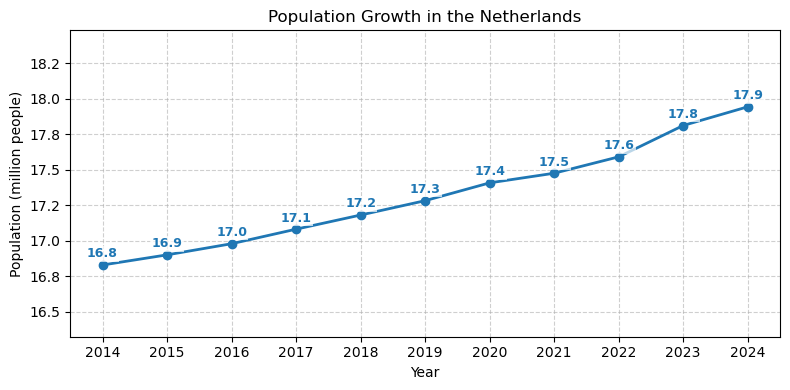

In [17]:
# === 1. Data inlezen ===
df = pd.read_csv('bontwikkeling.csv', sep=';', skiprows=3)

# Kolomnamen opschonen
df.columns = df.columns.str.strip()
df = df.rename(columns={
    'Unnamed: 0': 'Year',
    'Bevolking aan het begin van de periode': 'Population'
})

# Alleen numerieke rijen behouden
df = df[pd.to_numeric(df['Population'], errors='coerce').notna()]

# Omzetten naar numeriek
df['Year'] = df['Year'].astype(int)
df['Population'] = df['Population'].astype(int) / 1_000_000  # in miljoenen

# === 2. Plot met uniforme Warentuin-/mobiliteitsstijl ===
plt.figure(figsize=(8, 4))
ax = plt.gca()

# Lijn en markers
ax.plot(df['Year'], df['Population'],
        marker='o', color='tab:blue', linewidth=2)

# Titel en labels
ax.set_title("Population Growth in the Netherlands")
ax.set_xlabel("Year")
ax.set_ylabel("Population (million people)")

# Grid en asopmaak
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xticks(df['Year'])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Strakkere schaal (±3% marge)
ymin, ymax = df['Population'].min() * 0.97, df['Population'].max() * 1.03
ax.set_ylim(ymin, ymax)

# Labels bij datapunten
for x, y in zip(df['Year'], df['Population']):
    ax.text(
        x, y + (ymax - ymin) * 0.015,
        f"{y:.1f}",
        ha='center', va='bottom',
        fontsize=9, fontweight='bold',
        color='tab:blue',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
    )

plt.tight_layout()
plt.show()


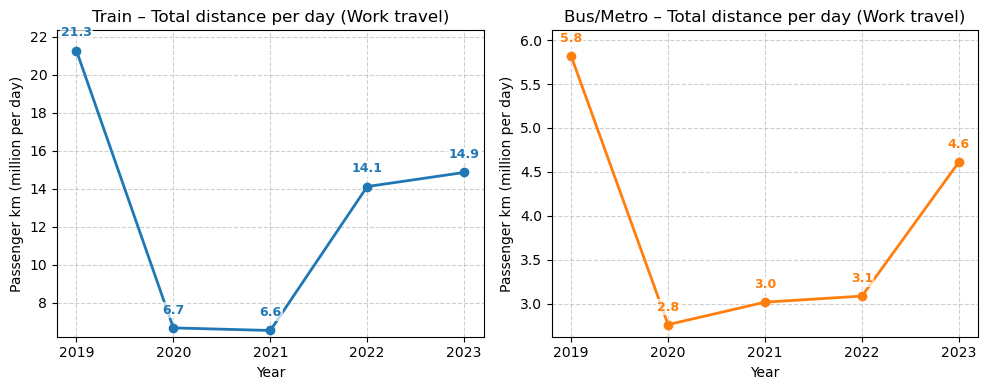

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. PT-trenddata inlezen ===
df = pd.read_csv("PT trend.csv", sep=';', skiprows=5)

# Kolommen correct instellen
df.columns = [
    "Periods", "Age", "Travel_motives",
    "Train_stages", "Train_distance", "Train_time",
    "BusMetro_stages", "BusMetro_distance", "BusMetro_time"
]

# Filter alleen woon-werkverkeer
df_work = df[df["Travel_motives"].str.contains("work", case=False, na=False)].copy()

# Jaar uit 'Periods' halen (ook bij 2019*)
df_work["Year"] = df_work["Periods"].str.extract(r"(\d{4})").astype(int)

# Zet numerieke kolommen om (komma’s vervangen door punten)
cols = ["Train_stages", "Train_distance", "BusMetro_stages", "BusMetro_distance"]
df_work[cols] = df_work[cols].apply(lambda x: x.astype(str).str.replace(",", ".")).astype(float)

# Bereken totaal per persoon per dag
df_work["Train_total_per_person"] = df_work["Train_stages"] * df_work["Train_distance"]
df_work["BusMetro_total_per_person"] = df_work["BusMetro_stages"] * df_work["BusMetro_distance"]

# === 2. Bevolkingsdata inlezen ===
pop = pd.read_csv("bontwikkeling.csv", sep=';', skiprows=4)
pop.columns = ["Year", "Population"]
pop = pop[pop["Year"].str.match(r"^\d{4}$", na=False)]
pop["Year"] = pop["Year"].astype(int)
pop["Population"] = pd.to_numeric(pop["Population"], errors="coerce")

# === 3. Samenvoegen en berekenen ===
merged = pd.merge(df_work, pop, on="Year", how="left")

# Bereken totaal aantal km per dag (in miljoenen)
merged["Train_total_km_per_day"] = merged["Train_total_per_person"] * merged["Population"] / 1_000_000
merged["BusMetro_total_km_per_day"] = merged["BusMetro_total_per_person"] * merged["Population"] / 1_000_000

# Controle: laat even zien of er data is
# Zorg dat Year integer is
merged["Year"] = merged["Year"].astype(int)

# === 4. Plot ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def plot_mode(ax, x, y, title, color):
    ax.plot(x, y, marker='o', color=color, linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Passenger km (million per day)")
    ax.set_xticks(x.astype(int))
    ax.grid(True, linestyle='--', alpha=0.6)

    if y.notna().any():
        ymin, ymax = y.min() * 0.95, y.max() * 1.05
        ax.set_ylim(ymin, ymax)

    # Verbeterde labels
    for xi, yi in zip(x, y):
        if pd.notna(yi):
            ax.text(
                xi, yi + (y.max() - y.min()) * 0.04,  # iets hogere offset
                f"{yi:.1f}",
                ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                color=color,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
            )


plot_mode(axes[0], merged["Year"], merged["Train_total_km_per_day"],
          "Train – Total distance per day (Work travel)", "tab:blue")
plot_mode(axes[1], merged["Year"], merged["BusMetro_total_km_per_day"],
          "Bus/Metro – Total distance per day (Work travel)", "tab:orange")

plt.tight_layout()
plt.show()


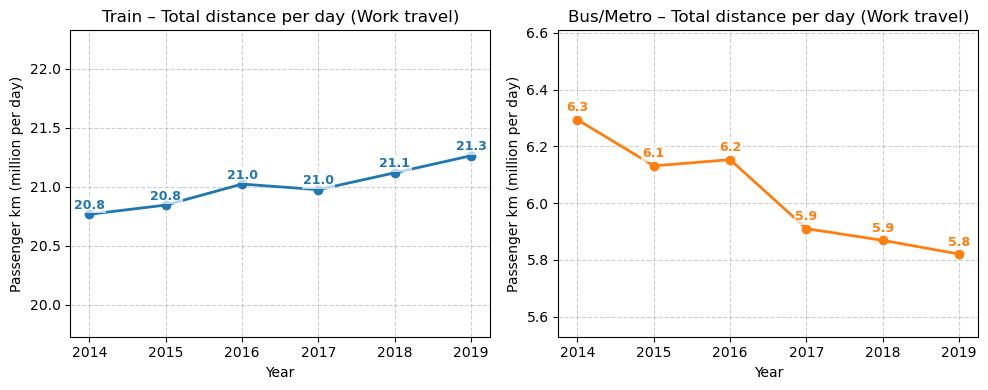

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Oude PT-trenddata (2014–2019) inlezen ===
df_before = pd.read_csv("PTbefore.csv", sep=';', skiprows=5)

# Kolommen instellen (zelfde structuur als nieuwe bestand)
df_before.columns = [
    "Periods", "Age", "Travel_motives",
    "Train_stages", "Train_distance", "Train_time",
    "BusMetro_stages", "BusMetro_distance", "BusMetro_time"
]

# Filter woon-werkverkeer
df_before_work = df_before[df_before["Travel_motives"].str.contains("work", case=False, na=False)].copy()

# Jaar uit 'Periods' halen
df_before_work["Year"] = df_before_work["Periods"].str.extract(r"(\d{4})").astype(int)

# Komma’s vervangen door punten en omzetten naar float
cols = ["Train_stages", "Train_distance", "BusMetro_stages", "BusMetro_distance"]
df_before_work[cols] = df_before_work[cols].apply(lambda x: x.astype(str).str.replace(",", ".")).astype(float)

# Bereken totaal per persoon per dag
df_before_work["Train_total_per_person"] = df_before_work["Train_stages"] * df_before_work["Train_distance"]
df_before_work["BusMetro_total_per_person"] = df_before_work["BusMetro_stages"] * df_before_work["BusMetro_distance"]

# === 2. Bevolkingsdata inlezen ===
pop = pd.read_csv("bontwikkeling.csv", sep=';', skiprows=4)
pop.columns = ["Year", "Population"]
pop = pop[pop["Year"].str.match(r"^\d{4}$", na=False)]
pop["Year"] = pop["Year"].astype(int)
pop["Population"] = pd.to_numeric(pop["Population"], errors="coerce")

# === 3. Samenvoegen en berekenen ===
merged_before = pd.merge(df_before_work, pop, on="Year", how="left")

# Bereken totaal aantal km per dag (in miljoenen)
merged_before["Train_total_km_per_day"] = (
    merged_before["Train_total_per_person"] * merged_before["Population"] / 1_000_000
)
merged_before["BusMetro_total_km_per_day"] = (
    merged_before["BusMetro_total_per_person"] * merged_before["Population"] / 1_000_000
)

# Zorg dat Year integer is
merged_before["Year"] = merged_before["Year"].astype(int)

# === 4. Plot ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def plot_mode(ax, x, y, title, color):
    ax.plot(x, y, marker='o', color=color, linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Passenger km (million per day)")
    ax.set_xticks(x.astype(int))
    ax.grid(True, linestyle='--', alpha=0.6)

    if y.notna().any():
        ymin, ymax = y.min() * 0.95, y.max() * 1.05
        ax.set_ylim(ymin, ymax)

    for xi, yi in zip(x, y):
        if pd.notna(yi):
            ax.text(
                xi, yi + (y.max() - y.min()) * 0.04,
                f"{yi:.1f}", ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                color=color,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
            )

plot_mode(axes[0], merged_before["Year"], merged_before["Train_total_km_per_day"],
          "Train – Total distance per day (Work travel)", "tab:blue")
plot_mode(axes[1], merged_before["Year"], merged_before["BusMetro_total_km_per_day"],
          "Bus/Metro – Total distance per day (Work travel)", "tab:orange")

plt.tight_layout()
plt.show()


In [20]:
import matplotlib.ticker as mticker

# Converteer naar “duizenden duizend-uren” → in de grafiek staat dus bijv. 21.4 = 21 400 uur
merged_before["Train_total_hours_per_day_thousand"] /= 1000
merged_before["BusMetro_total_hours_per_day_thousand"] /= 1000

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def plot_mode(ax, x, y, title, color):
    ax.plot(x, y, marker='o', color=color, linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Total travel time (thousand hours per day)")
    ax.set_xticks(x.astype(int))
    ax.grid(True, linestyle='--', alpha=0.6)

    # Y-limiets iets strakker (±3% marge)
    if y.notna().any():
        ymin, ymax = y.min() * 0.97, y.max() * 1.03
        ax.set_ylim(ymin, ymax)

    # Aslabels met 1 decimaal
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

    # Datapunten tonen
    for xi, yi in zip(x, y):
        if pd.notna(yi):
            ax.text(
                xi, yi + (y.max() - y.min()) * 0.015,
                f"{yi:.1f}", ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                color=color,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
            )

plot_mode(axes[0], merged_before["Year"], merged_before["Train_total_hours_per_day_thousand"],
          "Train – Total travel time per day (Work travel)", "tab:blue")
plot_mode(axes[1], merged_before["Year"], merged_before["BusMetro_total_hours_per_day_thousand"],
          "Bus/Metro – Total travel time per day (Work travel)", "tab:orange")

plt.tight_layout()
plt.show()


KeyError: 'Train_total_hours_per_day_thousand'